In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [10]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [25]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
interval = '1m'
pair = 'ETHUSDT'

In [29]:
from trade_utils import initialize_ohlc_df
try:
    df = pd.read_csv('data/' + pair + '-' + interval + '-binance.csv')
    df['OpenTime'] = pd.to_datetime(df['OpenTime'])
    df.set_index('OpenTime', inplace=True)
except FileNotFoundError:
    df = initialize_ohlc_df()


In [34]:
df.shape

(2037468, 5)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2037468 entries, 2017-08-17 04:00:00 to 2021-07-07 16:39:00
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   OpenPrice   float64
 1   HighPrice   float64
 2   LowPrice    float64
 3   ClosePrice  float64
 4   Volume      float64
dtypes: float64(5)
memory usage: 93.3 MB


In [36]:
df.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,301.13,301.13,301.13,301.13,0.42643
2017-08-17 04:01:00,301.13,301.13,301.13,301.13,2.75787
2017-08-17 04:02:00,300.00,300.00,300.00,300.00,0.09930
2017-08-17 04:03:00,300.00,300.00,300.00,300.00,0.31389
2017-08-17 04:04:00,301.13,301.13,301.13,301.13,0.23202


In [37]:
df.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-07-07 16:35:00,2351.16,2354.04,2350.66,2354.00,502.04345
2021-07-07 16:36:00,2353.58,2354.99,2352.96,2354.65,620.85308
2021-07-07 16:37:00,2354.65,2357.83,2354.24,2356.56,488.42514
2021-07-07 16:38:00,2356.56,2357.65,2355.20,2355.52,996.35444
2021-07-07 16:39:00,2355.52,2356.74,2355.51,2356.14,71.34119


In [33]:
from binance_utils import update_historical_data

df = update_historical_data(df, pair, interval)

In [39]:
# only data from 2020 until now are going to save
df = df[2020-1-1:]

filename = 'data/' + pair + '-' + interval + '-binance.csv'
df.to_csv(filename)

In [15]:
summaries = {'OpenPrice': 'first', 'HighPrice': 'max', 'LowPrice': 'min', 'ClosePrice': 'last', 'Volume': 'sum'}

df_1m = df.copy()

df_15m = df.resample('15min').agg(summaries)
df_15m.dropna(inplace=True)

df_1h = df.resample('1H').agg(summaries)
df_1h.dropna(inplace=True)

df_4h = df.resample('4H').agg(summaries)
df_4h.dropna(inplace=True)

df_1d = df.resample('1D').agg(summaries)
df_1d.dropna(inplace=True)

In [16]:
# select data to generate indicators
data = df_1h.copy()
#data = df_1d.copy()

In [ ]:
#filename = 'data/' + pair + '1d-binance.csv'
#data[data.index > '2021-03-01'][['HighPrice', 'LowPrice', 'ClosePrice']].to_csv(filename)

In [ ]:
data.sample(10)

In [17]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate daily returns
data['daily_return'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous day

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA90'] = sma(data['ClosePrice'], 90)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA90'] = ema(data['ClosePrice'], 90)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['signal'], data['MACDH'] = macd(data.ClosePrice)

# RSI
data['rsi'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [18]:
#filename = 'data/' + pair + '1h-indicators-binance.csv'
#data.to_csv(filename)

In [19]:
#limit data to plot
data = data['2021-6-1':]

In [20]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

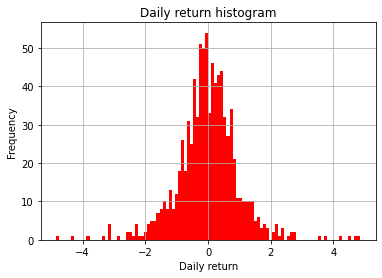

In [21]:
# Plot the histogram
data['daily_return'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

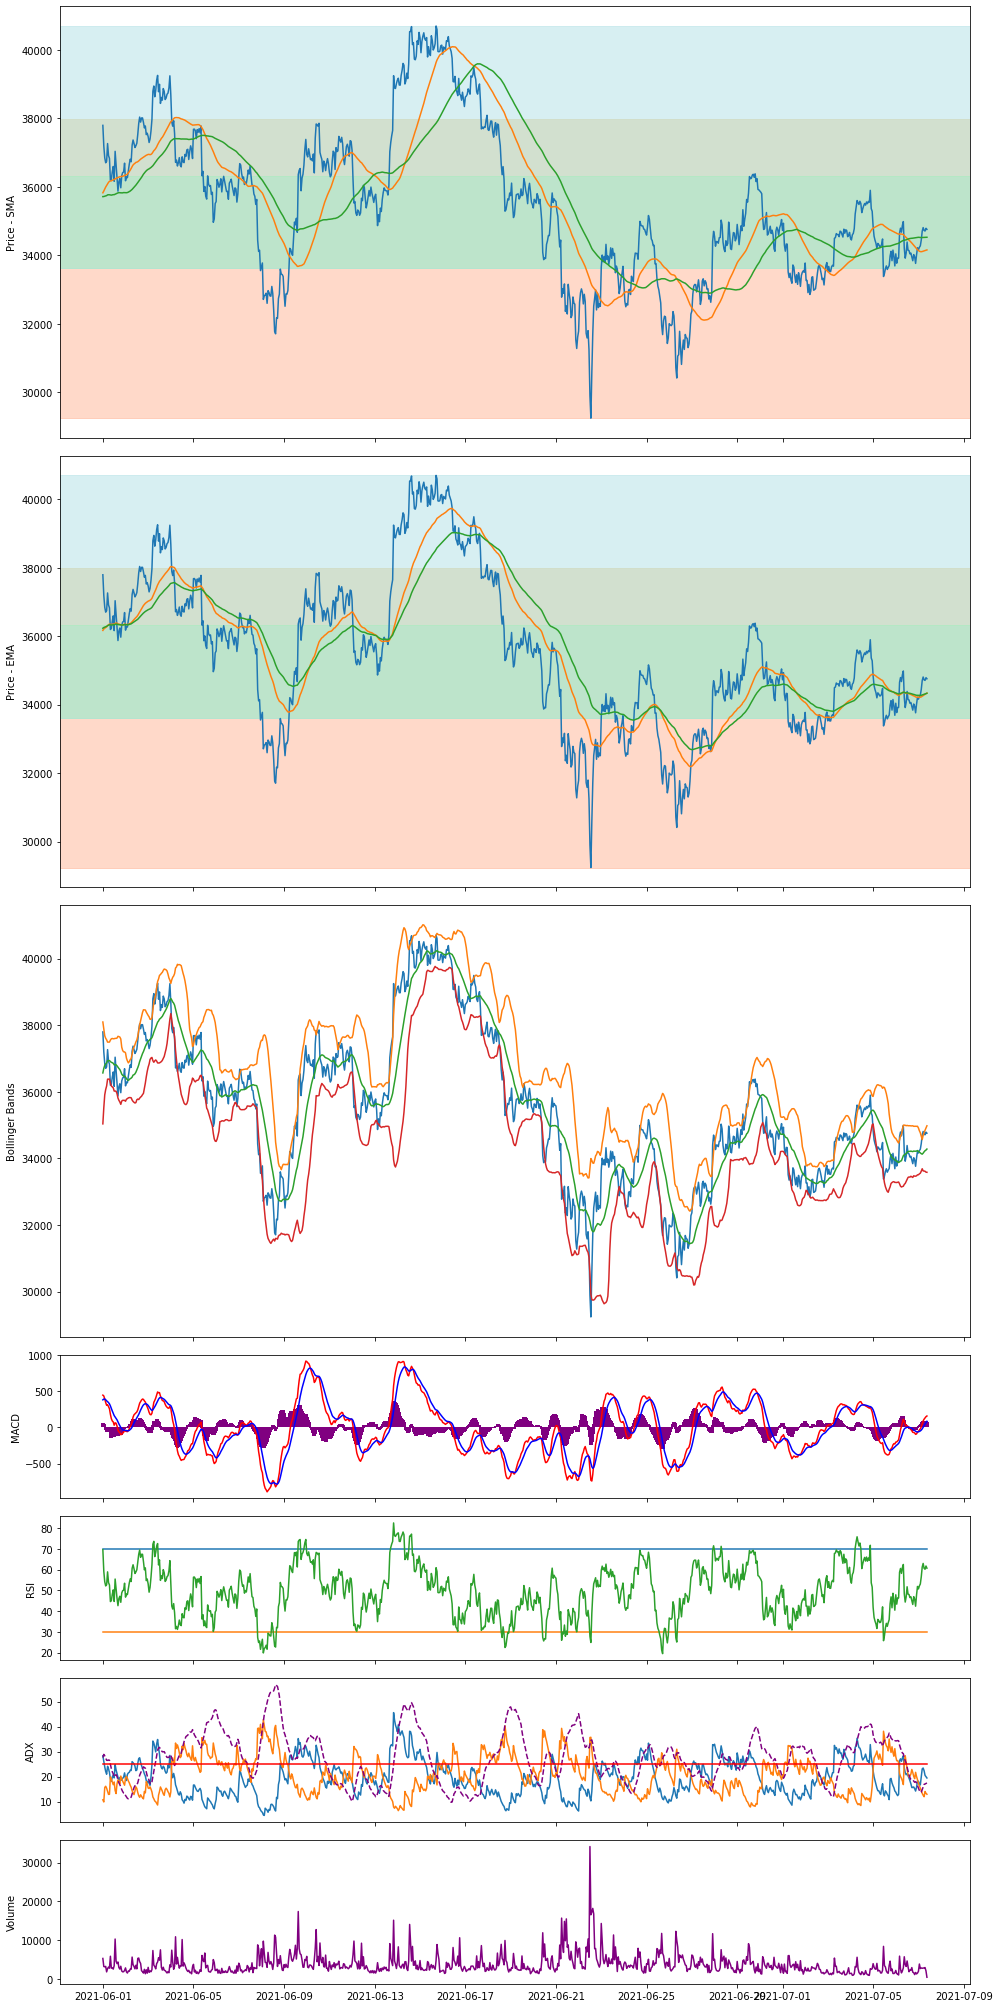

In [22]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA90']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA90']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.plot(data.index, data['signal'], label='Signal Line', color='blue')
ax4.bar(data.index, data['MACDH'], color="purple", width = timedelta(hours=4))
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['rsi'], label='rsi')
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
ax7.plot(data.index, data['Volume'], color='purple')
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [ ]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

In [ ]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_backtest = signal_strategy(price_data.copy(), signal, 'sma_cross')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [ ]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_backtest = signal_strategy(price_data.copy(), signal, 'ema_cross')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [ ]:
from backtest_utils import get_rsi_signal, signal_strategy

signal = get_rsi_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

In [ ]:
bt_backtest = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [ ]:
bt_result.display()

In [ ]:
bt_result.get_transactions()

In [ ]:
from backtest_utils import get_macd_signal, signal_strategy

signal = get_macd_signal(data[['signal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()


In [ ]:
bt_backtest = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [ ]:
bt_result.display()

In [ ]:
bt_result.get_transactions()

In [ ]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
sma30 = signal_above_strategy(price_data.copy(), data[['SMA30']].copy(), name='SMA30')
sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')

# Create benchmark strategy backtest
benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

In [ ]:
# Run all backtests and plot the resutls
#bt_results = bt.run(macd_bt, sma5, sma30, sma50, benchmark)
bt_results = bt.run(sma5, sma30, sma50, benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [ ]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)

## Real-time trade

In [ ]:
from binance.client import Client

from datetime import datetime
import time, json

In [ ]:
from binance_utils import get_twm
from binance import ThreadedWebsocketManager

from datetime import datetime
import time, json

df_real_time = pd.DataFrame(columns=[
        'OpenTime',
        'OpenPrice', 
        'HighPrice', 
        'LowPrice', 
        'ClosePrice', 
        'Volume'])

symbol = 'BTCUSDT'

twm = get_twm()
twm.start()

def handle_socket_message(msg):
    #print(f"message type: {msg['e']}")
    #print(msg)

    global df_real_time

    candle = msg['k']
    timestamp = candle['t'] / 1000
    timestamp = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

    is_candle_closed = candle['x']

    # Print this amount
    print("{} - Open: {} High: {} Low: {} Close: {} Volume: {}".format(
        timestamp, 
        candle['o'], 
        candle['h'], 
        candle['l'], 
        candle['c'],
        candle['v']))
    
    if is_candle_closed:
        print('candle closed')

        new_row = {
            'OpenTime':timestamp, 
            'OpenPrice':candle['o'], 
            'HighPrice':candle['h'], 
            'LowPrice':candle['l'], 
            'ClosePrice':candle['c'], 
            'Volume':candle['v']}

        #append row to the dataframe
        df_real_time = df_real_time.append(new_row, ignore_index=True)

twm.start_kline_socket(callback=handle_socket_message, symbol=symbol, interval='1m')

# let some data flow..
time.sleep(160)

twm.stop()

df_real_time.head()

In [ ]:
from binance_utils import init
from binance.client import Client

client = init()
candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1HOUR)